# Домашнее задание №10. Распознавание лиц и эмоций

In [1]:
!pip install facenet-pytorch==2.5.2

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from facenet_pytorch import MTCNN

## Задание

- (упрощенное/для тех, у кого нет вебкамеры) Нужно написать приложение, которое будет получать на вход изображения. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
- (более сложное) Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.

- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

## План работы

[0. Загрузка и просмотр данных](#section_0)

[1. Dataset и Dataloader](#section_1)
    
[2. Модель классификации жестов](#section_2)

[3. Модель детекции с последующей классификацией жестов](#section_3)

[4. Выводы](#section_4)

### 0. Загрузка и просмотр данных  <a id='section_0'></a>

In [267]:
#функция построения датасета
def get_data(directory):
    """
    Вход -- путь к папке с данными
    Выход -- датасет, содержащий путь к файлу и класс его картинки
    """
    data = pd.DataFrame()
    basedir = directory
    for man in os.listdir(basedir):
        for sign in os.listdir(basedir+man+'/'):
            for location in os.listdir(basedir+man+'/'+sign+'/'):
                data = data.append({'Sign':sign,'Location': basedir+man+'/'+sign+'/'+location},ignore_index=True)
    return data

In [268]:
#построение датасета с данными
data= get_data('data/leapGestRecog/train/')
data

,Location,Sign
0,data/leapGestRecog/train/00/01_palm/frame_00_0...,01_palm
1,data/leapGestRecog/train/00/01_palm/frame_00_0...,01_palm
2,data/leapGestRecog/train/00/01_palm/frame_00_0...,01_palm
3,data/leapGestRecog/train/00/01_palm/frame_00_0...,01_palm
4,data/leapGestRecog/train/00/01_palm/frame_00_0...,01_palm
...,...,...
19995,data/leapGestRecog/train/09/10_down/frame_09_1...,10_down
19996,data/leapGestRecog/train/09/10_down/frame_09_1...,10_down
19997,data/leapGestRecog/train/09/10_down/frame_09_1...,10_down
19998,data/leapGestRecog/train/09/10_down/frame_09_1...,10_down


In [269]:
# разделяем датасет на трейн и тест
data_train, data_test = train_test_split(data, test_size=0.25, random_state=13)
print(f'Тренировочный набор: {data_train.shape}')
print(f'Тестовый набор: {data_test.shape}')

Тренировочный набор: (15000, 2)
Тестовый набор: (5000, 2)


In [270]:
#тренировочный набор данных
data_train.head()

,Location,Sign
2511,data/leapGestRecog/train/01/03_fist/frame_01_0...,03_fist
14501,data/leapGestRecog/train/07/03_fist/frame_07_0...,03_fist
11955,data/leapGestRecog/train/05/10_down/frame_05_1...,10_down
11205,data/leapGestRecog/train/05/07_ok/frame_05_07_...,07_ok
8229,data/leapGestRecog/train/04/02_l/frame_04_02_0...,02_l


In [271]:
#тестовый набор данных
data_test.head()

,Location,Sign
10138,data/leapGestRecog/train/05/01_palm/frame_05_0...,01_palm
15088,data/leapGestRecog/train/07/06_index/frame_07_...,06_index
19626,data/leapGestRecog/train/09/09_c/frame_09_09_0...,09_c
1922,data/leapGestRecog/train/00/10_down/frame_00_1...,10_down
989,data/leapGestRecog/train/00/05_thumb/frame_00_...,05_thumb


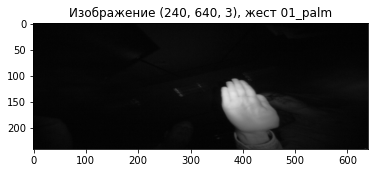

In [272]:
#просмотр загруженных данных
location = data_train['Location'][0]
sign = data_train['Sign'][0]
image = cv2.imread(location)
plt.imshow(image)
plt.title(f'Изображение {image.shape}, жест {sign}')
plt.show()

In [273]:
#число и названия классов
classes_train = data_train['Sign'].unique()
classes_test = data_test['Sign'].unique()
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['03_fist' '10_down' '07_ok' '02_l' '01_palm' '04_fist_moved' '06_index'
 '08_palm_moved' '09_c' '05_thumb']
test Classes - ['01_palm' '06_index' '09_c' '10_down' '05_thumb' '08_palm_moved'
 '03_fist' '04_fist_moved' '02_l' '07_ok']


In [274]:
#количество элементов каждого класса
print(data_train['Sign'].value_counts())
print(data_test['Sign'].value_counts())

09_c             1531
01_palm          1529
03_fist          1521
05_thumb         1510
07_ok            1509
08_palm_moved    1488
06_index         1487
10_down          1483
04_fist_moved    1473
02_l             1469
Name: Sign, dtype: int64
02_l             531
04_fist_moved    527
10_down          517
06_index         513
08_palm_moved    512
07_ok            491
05_thumb         490
03_fist          479
01_palm          471
09_c             469
Name: Sign, dtype: int64


In [275]:
#функции перевода класса в число и обратно
def sign_to_class(sign):
    """
    Вход -- название класса
    Выход -- число
    """
    if sign == '01_palm':
        return 0
    elif sign == '02_l':
        return 1
    elif sign == '03_fist':
        return 2
    elif sign == '04_fist_moved':
        return 3
    elif sign == '05_thumb':
        return 4
    elif sign == '06_index':
        return 5
    elif sign == '07_ok':
        return 6
    elif sign == '08_palm_moved':
        return 7
    elif sign == '09_c':
        return 8
    elif sign == '10_down':
        return 9
    
def digit_to_classname(digit):
    """
    Вход -- число, соответствуюшее классу
    Выход -- название класса
    """
    if digit == 0:
        return 'palm'
    elif digit == 1:
        return 'l'
    elif digit == 2:
        return 'fist'
    elif digit == 3:
        return 'fist_moved'
    elif digit == 4:
        return 'thumb'
    elif digit == 5:
        return 'index'
    elif digit == 6:
        return 'ok'
    elif digit == 7:
        return 'palm_moved'
    elif digit == 8:
        return 'c'
    elif digit == 9:
        return 'down'

### 1. Dataset и Dataloader <a id='section_1'></a>

In [276]:
#преобразование тренировочных и валидационных данных
train_tfms = tt.Compose([tt.ToPILImage(),
                         tt.Grayscale(num_output_channels=1), # Картинки черно-белые
                         # Настройки для расширения датасета
                         tt.Resize((48,48)),
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_tfms = tt.Compose([tt.ToPILImage(),
                        tt.Grayscale(num_output_channels=1), 
                        tt.Resize((48,48)),
                        tt.ToTensor()])

In [277]:
#класс датасета
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        # загружаем данные из датасета
        self.data = data
        self.transform = transform
        self.image_arr = self.data.iloc[:,0] # имена файлов картинок из датасета
        self.label_arr = self.data.iloc[:,1] # имена классв
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, index):
       # загружаем картинки
        img = cv2.imread(self.image_arr[index])
        if self.transform is not None:  #преобразование картинок
            img = self.transform(img)
        
        # загружаем классы
        sign = self.label_arr[index]
        sign_class = sign_to_class(sign) #переводим название класса в число

        return (img, sign_class)

In [278]:
#сбрасываем индексы
data_train.reset_index(drop=True,inplace=True)
data_test.reset_index(drop=True,inplace=True)

#создаем датасеты
train_data = CustomDataset(data_train, transform=train_tfms)
test_data = CustomDataset(data_test, transform=test_tfms)

#создаем даталодеры
train_data_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [279]:
#просматриваем размеры данных в даталоадере
for idx, batch in enumerate(train_data_loader):
    print(idx, 'Tensor_img: ', batch[0].shape)  
    print(idx, 'Sign_class: ', batch[1].shape)  
    break

0 Tensor_img:  torch.Size([256, 1, 48, 48])
0 Sign_class:  torch.Size([256])


torch.Size([1, 48, 48])
tensor(3) fist_moved


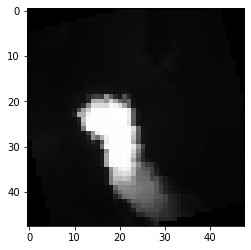

In [280]:
#просмариваем данные в даталоадере
for img, label in train_data_loader:
    print(img[0].shape)
    print(label[0], digit_to_classname(label[0]))
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

image: torch.Size([1, 48, 48])


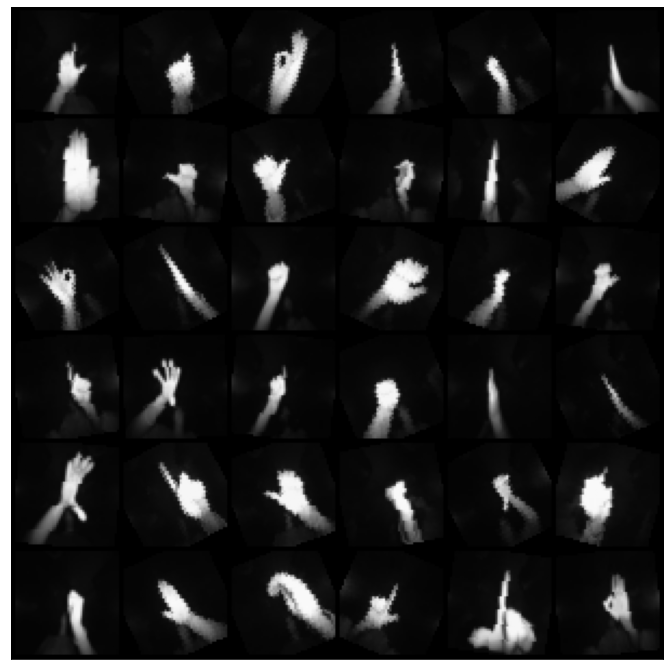

In [281]:
#просмотр случайных картинок датасета
def show_batch(train_data_loader):
    for images, labels in train_data_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:36], nrow=6).permute(1, 2, 0))
        break

show_batch(train_data_loader)      

### 2. Модель классификации жестов  <a id='section_2'></a>

In [286]:
#класс модели ResNet
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [665]:
#инициализация модели
model = ResNet(1, 10)
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [288]:
#обучение

epochs = 20
max_lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), max_lr)

epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        model.train()
        data = data
        labels = labels
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(test_data_loader):
        model.eval()
        data = data
        labels = labels
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        
    print(f'Epoch {epoch+1}, train loss: {np.mean(epoch_loss)}, test loss: {np.mean(test_epoch_loss)}')
    epoch_losses.append(epoch_loss)

Epoch 1, train loss: 5.869071334095325, test loss: 2.2548867225646974
Epoch 2, train loss: 1.772734149027679, test loss: 1.4738401412963866
Epoch 3, train loss: 0.8448353712841615, test loss: 1.2861450970172883
Epoch 4, train loss: 0.4789264414270045, test loss: 0.3245871692895889
Epoch 5, train loss: 0.28389088405390916, test loss: 1.8789608478546143
Epoch 6, train loss: 0.1665738895535469, test loss: 0.5770413666963577
Epoch 7, train loss: 0.129191627378686, test loss: 0.6523200124502182
Epoch 8, train loss: 0.0854501525666249, test loss: 0.3757075026631355
Epoch 9, train loss: 0.06353103962995238, test loss: 4.636943721771241
Epoch 10, train loss: 0.04611433579949504, test loss: 0.0802901091054082
Epoch 11, train loss: 0.03302590351678052, test loss: 0.4203287959098816
Epoch 12, train loss: 0.03533331311102641, test loss: 0.060343865863978864
Epoch 13, train loss: 0.04960911659429134, test loss: 1.107809618115425
Epoch 14, train loss: 0.032781930892901906, test loss: 0.3508288025856

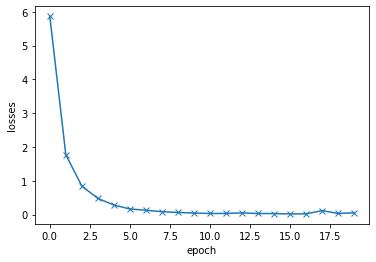

In [289]:
#график функции ошибок по эпохам
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [290]:
#сохранение модели
torch.save(model, 'data/leapGestRecog/sign_detection_model_20.pth')

In [640]:
#загрузка модели
net = torch.load('data/leapGestRecog/sign_detection_model_20.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

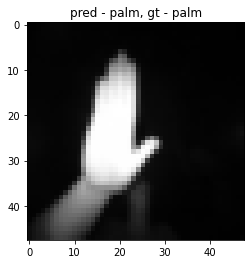

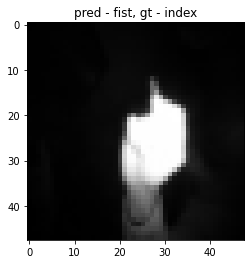

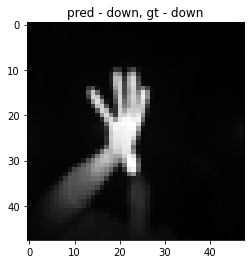

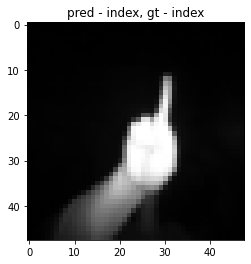

In [641]:
#оценка моедли на валидационном датасете
with torch.no_grad():
    for i, data in enumerate(test_data_loader, 3):
        images, labels = data[0], data[1]
        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

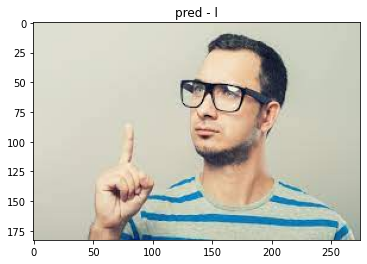

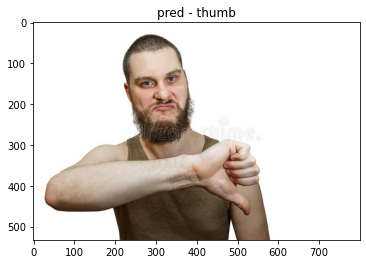

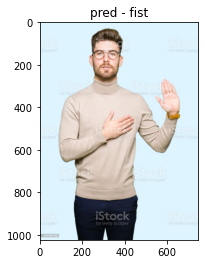

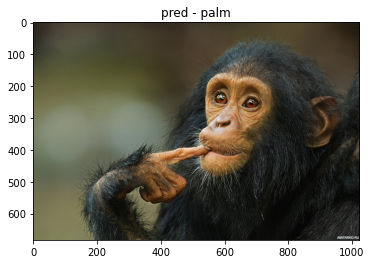

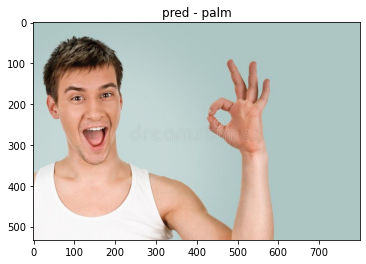

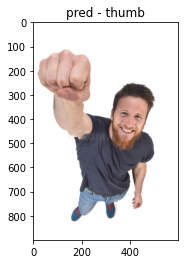

In [644]:
#оценка модели на тестовых изображениях
test_photo_index = 'data/leapGestRecog/test/test_index_1.jpg'
test_photo_down = 'data/leapGestRecog/test/test_down_1.jpg'
test_photo_palm = 'data/leapGestRecog/test/test_palm_1.jpg'
test_photo_not_human = 'data/leapGestRecog/test/test_not_human_1.jpg'
test_photo_ok = 'data/leapGestRecog/test/test_ok_1.jpg'
test_photo_fist = 'data/leapGestRecog/test/test_fist_1.jpg'

for test_photo in [test_photo_index, test_photo_down, test_photo_palm, test_photo_not_human, test_photo_ok, test_photo_fist]:
    image = cv2.imread(test_photo)
    image_model = test_tfms(image).unsqueeze(1)#torch.Size([1, 1, 48, 48])
    output_model = net(image_model)
    plt.title(f'pred - {digit_to_classname(output_model[0].argmax())}')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

### 3. Модель детекции с последующей классификацией жестов  <a id='section_3'></a>

In [645]:
#класс модели
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.emodel = torch.load('data/leapGestRecog/sign_detection_model_20.pth')
        self.emodel.eval()

    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'palm'
        elif digit == 1:
            return 'l'
        elif digit == 2:
            return 'fist'
        elif digit == 3:
            return 'fist_moved'
        elif digit == 4:
            return 'thumb'
        elif digit == 5:
            return 'index'
        elif digit == 6:
            return 'ok'
        elif digit == 7:
            return 'palm_moved'
        elif digit == 8:
            return 'c'
        elif digit == 9:
            return 'down'
       

    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(path_to_img)
        
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        
        if boxes is not None:
            image_model = test_tfms(frame).unsqueeze(1)#torch.Size([1, 1, 48, 48])
            output_model = net(image_model)
            plt.title(f'pred - {digit_to_classname(output_model[0].argmax())}')
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.show()
        else:
            print('It is not a human')
        
        
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)

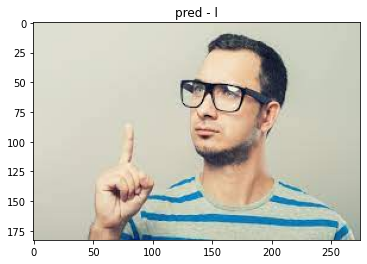

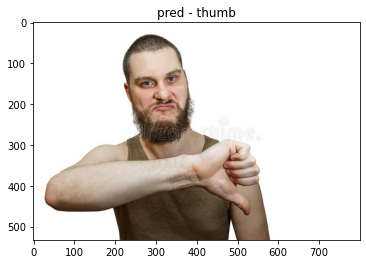

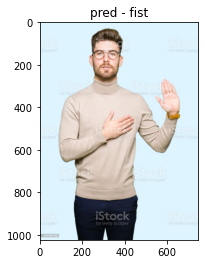

It is not a human


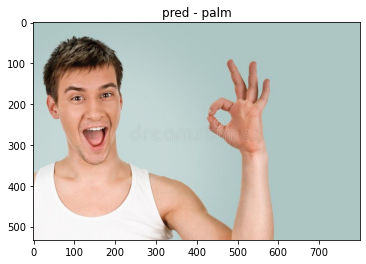

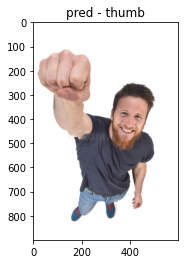

In [646]:
#работа модели на тестовых картинках
for test_photo in [test_photo_index, test_photo_down, test_photo_palm, test_photo_not_human, test_photo_ok, test_photo_fist]:
    fcd.run(test_photo)

### 4. Выводы  <a id='section_4'></a>

Модель классификации жестов показывает хорошие результаты на валидационных данных и плохие на тестовых, хотя обработка входных данных одинакова.